In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [13]:
clothes_info = {
    0: '0_coat', 1: '1_padding', 2: '2_shortsleeve',
    3: '3_longsleeve', 4: '4_shirt', 5: '5_pants', 6: '6_dress'
}

# data augmentation

In [5]:
base_dir = '/content/drive/MyDrive/ktintern/datasets'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [15]:
input_size = (299, 299)

train_datagen = ImageDataGenerator(rescale=1./255.,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  target_size=input_size)

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=input_size)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  target_size=input_size)

Found 461 images belonging to 6 classes.
Found 129 images belonging to 6 classes.
Found 69 images belonging to 6 classes.


## transfer learning - inception v3 , just classifier

In [ ]:
inceptioinV3 = tf.keras.applications.InceptionV3(include_top=True)
base_inputs = inceptioinV3.layers[0].input
base_outputs = inceptioinV3.layers[-2].output
classifier = tf.keras.layers.Dense(11)(base_outputs)
inceptioinV3_model = tf.keras.Model(inputs=base_inputs, outputs=classifier)

inceptioinV3_model.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
inceptioinV3_model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

checkpoint_path = '/content/drive/MyDrive/ktintern/checkpoints/'
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path, 'inceptionV3_model.ckpt'),
                                                   save_weights_only=True,
                                                   monitor = 'val_loss',
                                                   verbose=1,
                                                   save_best_only=True
                                                  ) 

In [ ]:
inceptioinV3_history = inceptioinV3_model.fit(train_generator,
                                              validation_data=validation_generator,
                                              epochs=30,
                                              callbacks=[cb_checkpoint, early_stopping]
                                              )

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.5919 - accuracy: 0.4818 
Epoch 00001: val_loss improved from inf to 13.79986, saving model to /content/drive/MyDrive/ktintern/models/inceptionV3_model.ckpt
17/17 [==============================] - 382s 22s/step - loss: 1.5919 - accuracy: 0.4818 - val_loss: 13.7999 - val_accuracy: 0.0545
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.2365 - accuracy: 0.6121 
Epoch 00002: val_loss improved from 13.79986 to 11.04033, saving model to /content/drive/MyDrive/ktintern/models/inceptionV3_model.ckpt
17/17 [==============================] - 331s 19s/step - loss: 1.2365 - accuracy: 0.6121 - val_loss: 11.0403 - val_accuracy: 0.0909
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.9348 - accuracy: 0.7030 
Epoch 00003: val_loss improved from 11.04033 to 10.42093, saving model to /content/drive/MyDrive/ktintern/models/inceptionV3_model.ckpt
17/17 [==============================] - 333s 20

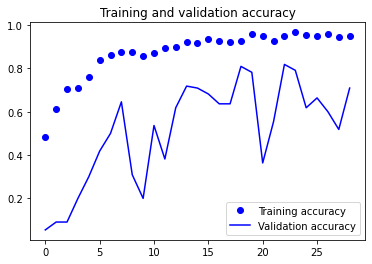

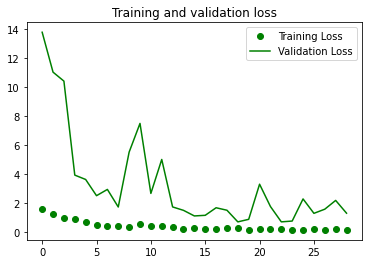

In [ ]:
acc = inceptioinV3_history.history['accuracy']
val_acc = inceptioinV3_history.history['val_accuracy']
loss = inceptioinV3_history.history['loss']
val_loss = inceptioinV3_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
inceptioinV3_model.load_weights(os.path.join(checkpoint_path, 'inceptionV3_model.ckpt'))

loss, acc = inceptioinV3_model.evaluate(test_generator, verbose=2)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

6/6 - 27s - loss: 0.5412 - accuracy: 0.8455 - 27s/epoch - 4s/step
복원된 모델의 정확도: 84.55%


In [ ]:
inceptioinV3_model.save(os.path.join(checkpoint_path, 'inceptionV3_model.h5'))

## transfer learning - inception v3 , fine tunning

In [16]:
inception_V3 = tf.keras.applications.InceptionV3(weights='imagenet',input_shape=(299,299,3), include_top=True)

for layer in inception_V3.layers[:]:
  layer.trainable = True

base_inputs = inception_V3.layers[0].input
base_outputs = inception_V3.layers[-2].output
classifier = tf.keras.layers.Dense(6, activation='softmax')(base_outputs)
inceptionV3_ft_model = tf.keras.Model(inputs=base_inputs, outputs=classifier)

inceptionV3_ft_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 149, 149, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

In [17]:
inceptionV3_ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)
checkpoint_path = '/content/drive/MyDrive/ktintern/checkpoints/'
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_path, 'inceptionV3_ft_model_2.ckpt'),
                                                   save_weights_only=True,
                                                   monitor = 'val_loss',
                                                   verbose=1,
                                                   save_best_only=True
                                                  ) 

In [19]:
inceptioinV3_ft_history = inceptionV3_ft_model.fit(train_generator,
                                                   validation_data=validation_generator,
                                                   epochs=50,
                                                   callbacks=[cb_checkpoint, early_stopping]
                                                   )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24/24 [==============================] - ETA: 0s - loss: 1.1250 - accuracy: 0.6638 
Epoch 00001: val_loss improved from inf to 47.91960, saving model to /content/drive/MyDrive/ktintern/checkpoints/inceptionV3_ft_model_2.ckpt
24/24 [==============================] - 492s 20s/step - loss: 1.1250 - accuracy: 0.6638 - val_loss: 47.9196 - val_accuracy: 0.1550
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.8728 - accuracy: 0.7115 
Epoch 00002: val_loss improved from 47.91960 to 10.57261, saving model to /content/drive/MyDrive/ktintern/checkpoints/inceptionV3_ft_model_2.ckpt
24/24 [==============================] - 459s 19s/step - loss: 0.8728 - accuracy: 0.7115 - val_loss: 10.5726 - val_accuracy: 0.1550
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.8243 
Epoch 00003: val_loss improved from 10.57261 to 9.58138, saving model to /content/drive/MyDrive/ktintern/checkpoints/inceptionV3_ft_model_2.ckpt
24/24 [=======================

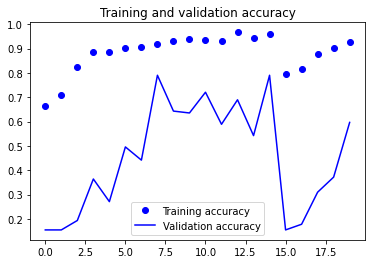

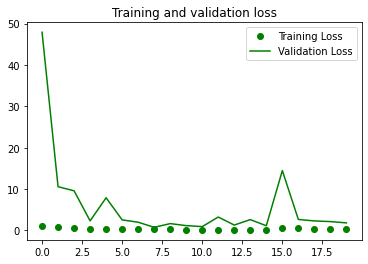

In [20]:
acc = inceptioinV3_ft_history.history['accuracy']
val_acc = inceptioinV3_ft_history.history['val_accuracy']
loss = inceptioinV3_ft_history.history['loss']
val_loss = inceptioinV3_ft_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
inceptionV3_ft_model.save(os.path.join(checkpoint_path, 
                                       'inceptionV3_ft_model_2.h5'))

In [22]:
inceptionV3_ft_model = tf.keras.models.load_model(os.path.join(checkpoint_path, 
                                                               'inceptionV3_ft_model_2.h5'))

loss, acc = inceptionV3_ft_model.evaluate(test_generator, verbose=2)
print("모델의 테스트 정확도: {:5.2f}%".format(100*acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 - 20s - loss: 2.8248 - accuracy: 0.6232 - 20s/epoch - 5s/step
모델의 테스트 정확도: 62.32%
